In [1]:
from matplotlib import pyplot as plt
from matplotlib import patches
import rasterio
from rasterio.plot import show as rastershow

import numpy as np
import pandas as pd
import os
import glob

import geopandas as gpd

from shapely.geometry import Point, Polygon

## Quick check for processed data

After running the preprocessing script, run this notebook for a quick sanity check of the processed outputs.

All data is located in `/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/`.

These are all the labeled tiles:

In [2]:
shapes = np.sort(glob.glob('/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_*.shp'))

In [3]:
shapes

array(['/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_0_0.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_0_1.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_16_19.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_17_18.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_17_19.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_18_17.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_18_18.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_18_19.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_19_17.shp',
       '/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_19_18.shp',
       '/work/

In [4]:
print(f'Number of available shape files for tiles: {len(shapes)}')

Number of available shape files for tiles: 12


We process one of the label files and check the coordinate reference system (CRS). The label files need to be cast to the same CRS as the raster images. They are given in `EPSG:4326` and are now cast to `EPSG:25832`.

In [5]:
polygons = gpd.read_file('/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/label_tile_1_1.shp')
polygons.crs

In [6]:
polygons

,class,geometry
0,0,"POLYGON ((11.94129 51.50303, 11.94129 51.50304..."
1,0,"POLYGON ((11.9412 51.50309, 11.9412 51.50309, ..."
2,0,"POLYGON ((11.94111 51.50308, 11.94113 51.50308..."
3,0,"POLYGON ((11.94103 51.50309, 11.94105 51.50309..."
4,0,"POLYGON ((11.94212 51.50307, 11.94214 51.50307..."
...,...,...
71,1,"POLYGON ((11.94201 51.50321, 11.94202 51.50322..."
72,0,"POLYGON ((11.94199 51.50328, 11.942 51.50329, ..."
73,2,"POLYGON ((11.94217 51.50327, 11.9422 51.50327,..."
74,0,"POLYGON ((11.94207 51.50288, 11.94208 51.50289..."


In [7]:
rastertif = rasterio.open(os.path.join('/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/', 'tiles', 'tile_0_1.tif'))
rastertif.crs

CRS.from_epsg(25832)

In [8]:
for shape in shapes:
    print(gpd.read_file(shape).crs)

None
None
EPSG:25832
EPSG:25832
EPSG:25832
EPSG:25832
EPSG:25832
EPSG:25832
EPSG:25832
EPSG:25832
EPSG:25832
None


In [9]:
polygons = polygons.set_crs(epsg=4326) # needed this explicitly
polygons = polygons.to_crs(epsg=25832)
polygons.crs

<Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.01, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

For preprocessing and plots, we need all polygons combined in one file. This is created here and saved in `/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/all_labels.shp`.

In [10]:
def fix_crs(shape, is_crs=4326, target_crs=25832):
    '''Fix the CRS if necessary'''
    if shape.crs is None: # naive coords
        shape.crs = is_crs

    return shape.to_crs(epsg=target_crs)

In [11]:
all_polygons = pd.concat([fix_crs(gpd.read_file(shape)).assign(tile=shape) for shape in shapes])
#all_polygons.drop(columns='tile').to_file('/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/all_labels_class0-2.shp')

In [12]:
#all_polygons = all_polygons[all_polygons['class'] < 2]
#all_polygons.drop(columns='tile').to_file('/work/ka1176/shared_data/2024-ufz-deeptree/polygon-labelling/labels/all_labels.shp')

In [13]:
all_polygons.head()

,class,geometry,tile
0,0,"POLYGON ((704006.919 5709953.981, 704007.922 5...",/work/ka1176/shared_data/2024-ufz-deeptree/pol...
1,0,"POLYGON ((704029.35 5709936.794, 704030.126 57...",/work/ka1176/shared_data/2024-ufz-deeptree/pol...
2,0,"POLYGON ((704032.327 5709930.838, 704032.781 5...",/work/ka1176/shared_data/2024-ufz-deeptree/pol...
3,0,"POLYGON ((704041.52 5709926.631, 704043.268 57...",/work/ka1176/shared_data/2024-ufz-deeptree/pol...
4,0,"POLYGON ((704005.203 5709932.327, 704006.951 5...",/work/ka1176/shared_data/2024-ufz-deeptree/pol...


In [14]:
all_polygons.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 440 entries, 0 to 75
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   class     440 non-null    int64   
 1   geometry  440 non-null    geometry
 2   tile      440 non-null    object  
dtypes: geometry(1), int64(1), object(1)
memory usage: 13.8+ KB


### Check the preprocessed raster files

We are starting with 
- tiles
- labels

In preprocessing, we created
- masks
- outlines
- distance transforms

In [15]:
tiles = [shape.replace('labels/', 'tiles/').replace('label_', '').replace('.shp', '.tif') for shape in shapes]
masks = [shape.replace('labels/', 'masks/').replace('label_tile_', 'mask_').replace('.shp', '.tif') for shape in shapes]
outlines = [shape.replace('labels/', 'outlines/').replace('label_tile_', 'outline_').replace('.shp', '.tif') for shape in shapes]
distance_transforms = [shape.replace('labels/', 'dist_trafo/').replace('label_tile_', 'dist_trafo_').replace('.shp', '.tif') for shape in shapes]

In [16]:
all_rastertifs = [rasterio.open(tile) for tile in tiles]
all_bounds = [rastertif.bounds for rastertif in all_rastertifs]
all_extents = [(b.left, b.bottom, b.right, b.top) for b in all_bounds]

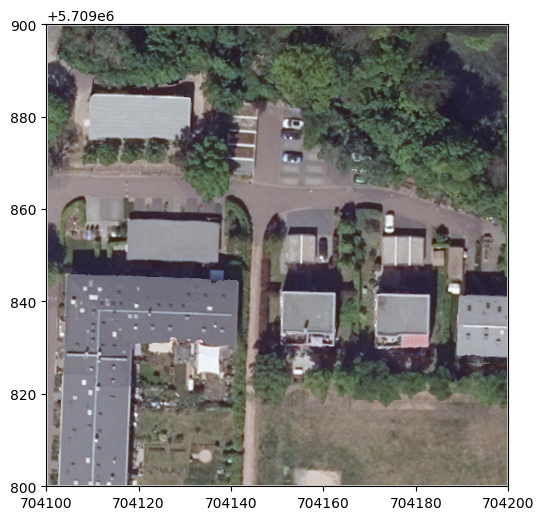

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# add original tiles
for rastertif in all_rastertifs:
    rastershow(rastertif, ax=ax)

# add bounding boxes to display
for extent in all_extents:
    rc = patches.Rectangle((extent[0], extent[1]), extent[2]-extent[0], extent[3]-extent[1],
                           lw=2, fc='none', ec='lightgray',
                          )
    ax.add_patch(rc)

#### Sanity check for masks

The following plot shows all the labeled tiles (RGB images) and the labeled polygons (cyan). The masks are overlayed in blue.

The cyan outlines should match the masks.

/tmp/ipykernel_886313/2011416661.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


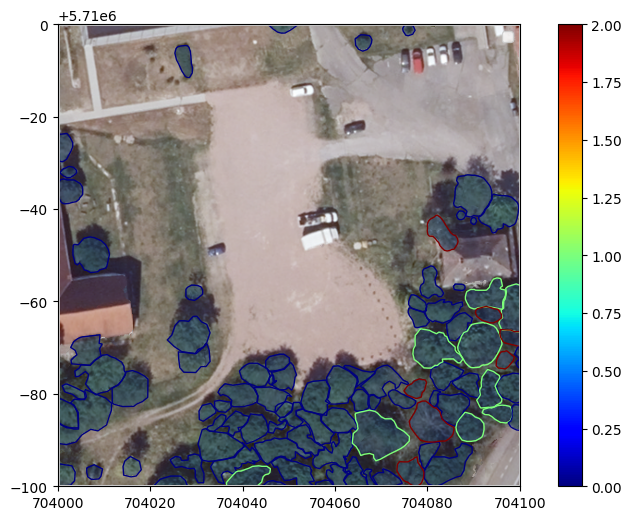

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# add original tiles
for rastertif in all_rastertifs:
    rastershow(rastertif, ax=ax)
    break

# all labeled polygons
all_polygons.plot(column='class', ax=ax, facecolor='none', cmap='jet', legend=True)

# check if mask is correct
for mask in masks:
    rastershow(rasterio.open(mask), ax=ax, alpha=0.35, cmap='Blues_r', with_bounds=True)
    break

# add bounding boxes to display
for extent in all_extents:
    rc = patches.Rectangle((extent[0], extent[1]), extent[2]-extent[0], extent[3]-extent[1],
                           lw=2, fc='none', ec='lightgray',
                          )
    ax.add_patch(rc)

ax.legend()

In [19]:
len(all_rastertifs)

12

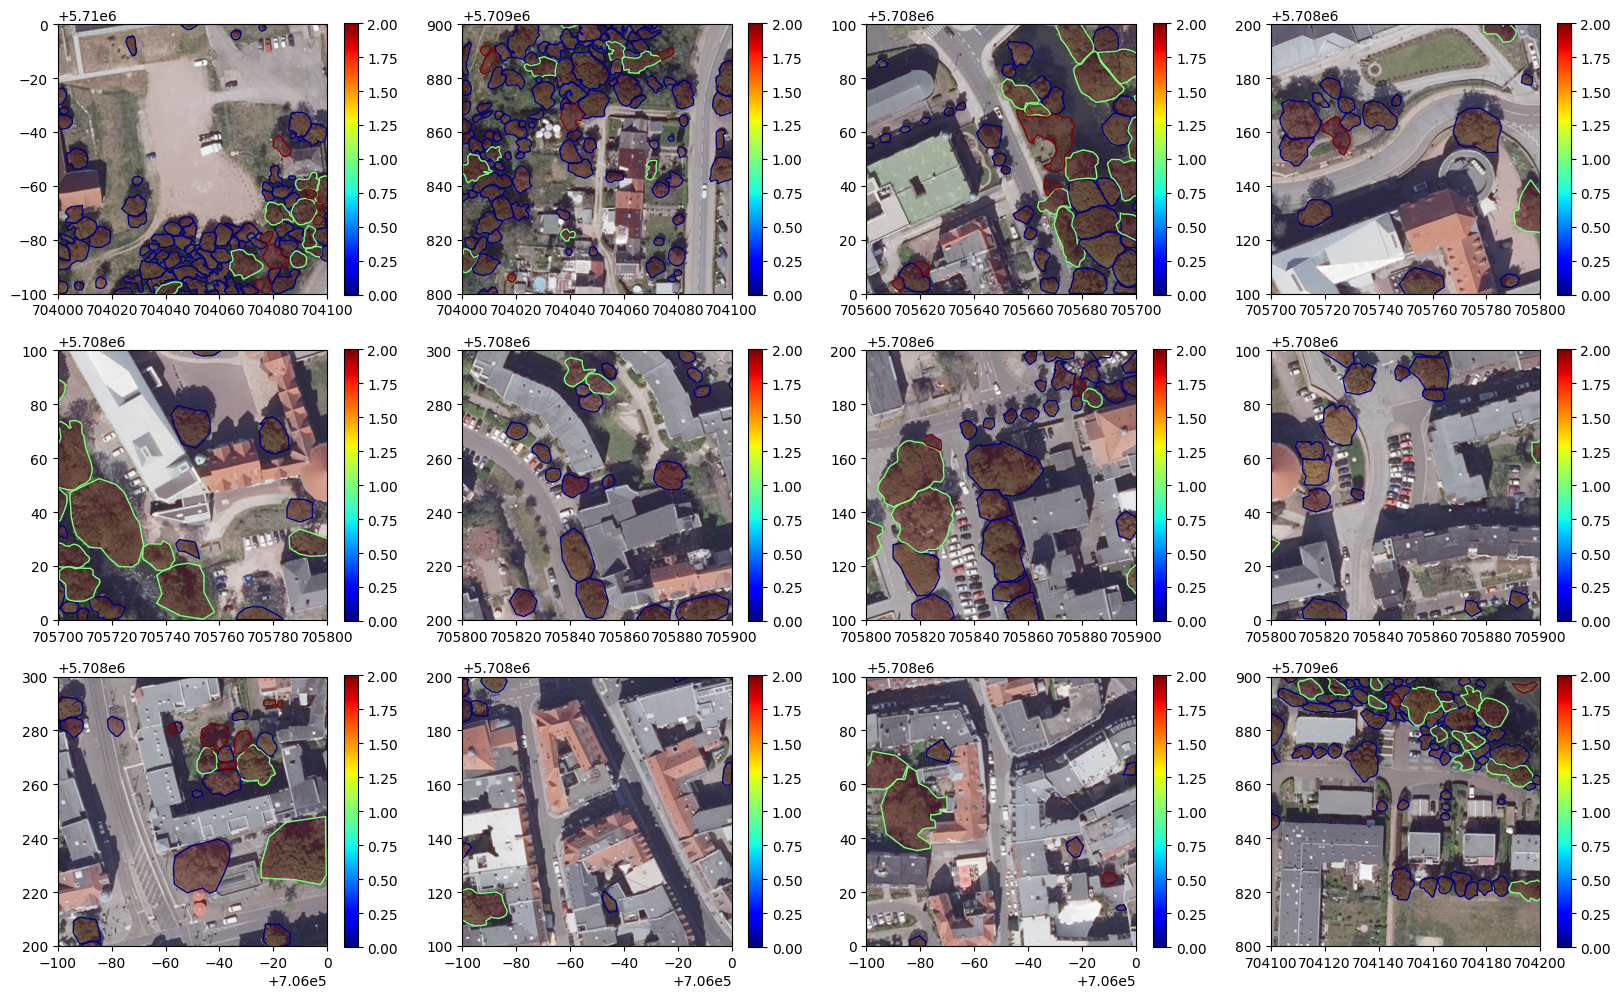

In [20]:
fig, axs = plt.subplots(3, 4, figsize=(20, 12))
axs = axs.flatten()

# add original tiles
for rastertif, mask, ax in zip(all_rastertifs, masks, axs):
    rastershow(rastertif, ax=ax)

    # all labeled polygons
    all_polygons.plot(column='class', ax=ax, facecolor='none', cmap='jet', legend=True)

    # check if mask is correct
    rastershow(rasterio.open(mask), ax=ax, alpha=0.35, cmap='Reds_r', with_bounds=True)


<Axes: >

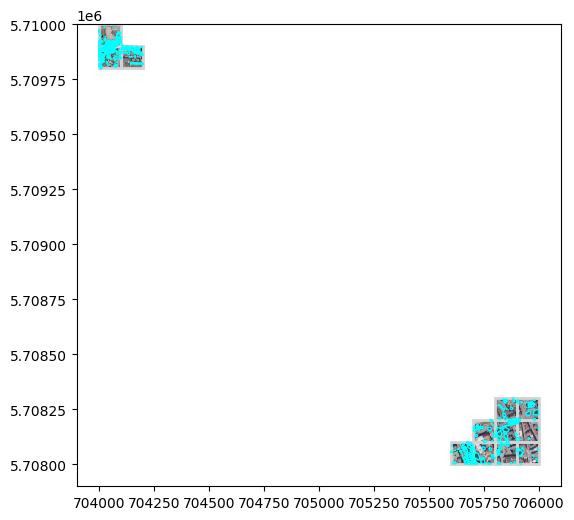

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# add original tiles
for rastertif in all_rastertifs:
    rastershow(rastertif, ax=ax)

# check if mask is correct
for mask in masks:
    rastershow(rasterio.open(mask), ax=ax, alpha=0.35, cmap='Blues_r', with_bounds=True)

# add bounding boxes to display
for extent in all_extents:
    rc = patches.Rectangle((extent[0], extent[1]), extent[2]-extent[0], extent[3]-extent[1],
                           lw=2, fc='none', ec='lightgray',
                          )
    ax.add_patch(rc)

# all labeled polygons
all_polygons.plot(column='tile', ax=ax, facecolor='none', edgecolor='cyan')

<Axes: >

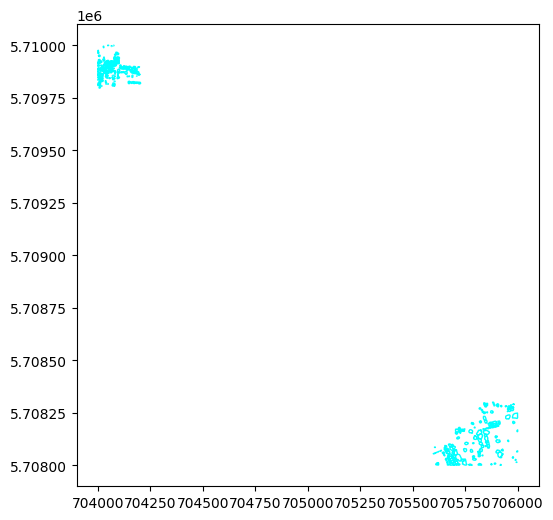

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# all labeled polygons
all_polygons.plot(column='class', ax=ax, facecolor='none', edgecolor='cyan')

#### Sanity check for outlines

The outlines are a bit hard to see in the overlay, so we perform the sanity check by comparing them against the masks. The outlines (red) should match the polygons (blue).

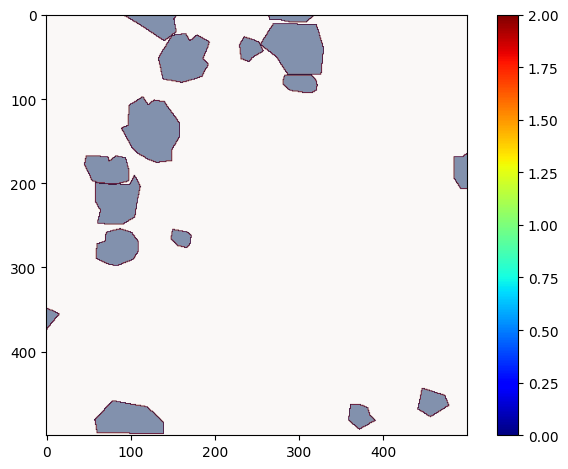

In [23]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

k = 7 # tile index

mask = rasterio.open(masks[k]).read()
ax.imshow(mask.squeeze(), cmap='Blues')



all_polygons.plot(column='class', ax=ax, facecolor='none', cmap='jet', legend=True)

outline = rasterio.open(outlines[k]).read()
ax.imshow(outline.squeeze(), cmap='Reds', alpha=0.5)

fig.tight_layout()
plt.show()

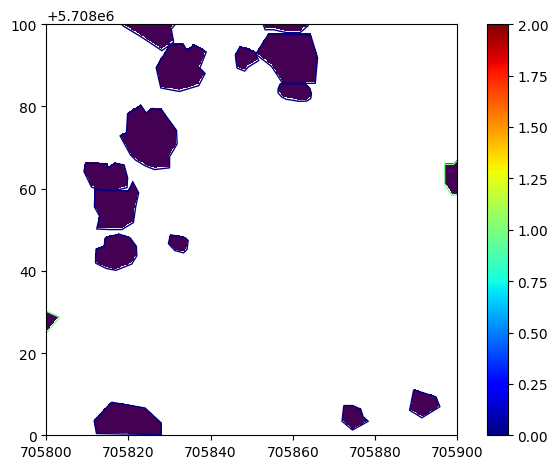

In [24]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

k = 7 # tile index





all_polygons.plot(column='class', ax=ax, facecolor='none', cmap='jet', legend=True)
rastershow(rasterio.open(masks[k]), ax=ax)

#outline = rasterio.open(outlines[k]).read()
#ax.imshow(outline.squeeze(), cmap='Reds', alpha=0.5)

fig.tight_layout()
plt.show()

#### Sanity check for distance transforms

The distance transforms denotes the distance of a point within the polygon to its boundary. Again, the shapes should match. The heatmap colors inside the polygons should reflect the distance to the boundary.

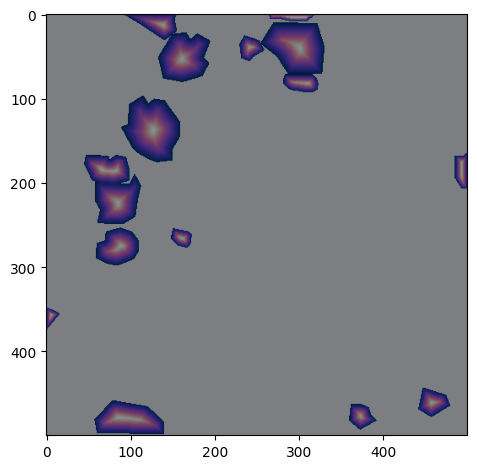

In [25]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

mask = rasterio.open(masks[k]).read()
ax.imshow(mask.squeeze(), cmap='Blues')

dist_trafo = rasterio.open(distance_transforms[k]).read()

ax.imshow(dist_trafo.squeeze(), cmap='magma', alpha=0.5)

fig.tight_layout()
plt.show()